In [1]:
# Verify that we are using the correct Python (/home/ata/miniconda3/envs/ml/bin/)
!which python
!which jupyter

/home/ata/miniconda3/envs/ml-2/bin/python
/home/ata/miniconda3/envs/ml-2/bin/jupyter


In [3]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
%matplotlib widget

2025-01-09 15:16:30.048466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 15:16:30.051351: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 15:16:30.058909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736417790.072534 2959958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736417790.076618 2959958 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 15:16:30.094338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

#### Fetch pair data

In [4]:
# Initialize Binance client with your API credentials
# dotenv_path = Path('.env-secret')
# load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client & initialize it
pair = "BTCUSDT"
time_delta = 12
db_name = pair + "_1min_" + str(time_delta) + "weeks.db"
db_name = "BTCUSDT_1min_dry_run.db"             # For dry run testing
binance_client = BinanceClient(db_name)
binance_client.set_interval("1m")
batch_feature = BatchFeatures()


#### Fecth Data from Binance

In [3]:

# Create connection to fetch data
binance_client.make(api_key, api_secret)

# Get current server time
server_time = binance_client.get_server_time()

# Compute start and end time for the last x hours
server_time_dt = datetime.fromtimestamp(server_time['serverTime'] / 1000, tz=datetime.timezone.utc if hasattr(datetime, 'timezone') else None)
end_date = server_time_dt
# start_date = server_time_dt - timedelta(hours=10)
start_date = server_time_dt - timedelta(weeks=time_delta)
start_date_str = int(start_date.timestamp() * 1000)  # Convert to milliseconds
end_date_str = int(end_date.timestamp() * 1000)      # Convert to milliseconds

# Fetch data
data = binance_client.fetch_data(pair, start_date_str, end_date_str)
binance_client.store_data_to_db(pair, data)

# Check if data is fetched
if not data.empty:
    df = data
else:
    print("No data found!!!.")

Fetching data from Binance API...


#### Fetch data from db

In [5]:
#Fetch data from db
df = binance_client.fetch_data_from_db(pair)

Feature engineering

In [6]:
# Feature Engineering (mind the order since some features are dependent on others)
bf = BatchFeatures()

# Must-have features

# EMA: Compute for short-term and long-term spans
bf.calculate_ema(df, spans=[5, 10, 50])  # Short-term (10), Long-term (50)

# MACD: Standard MACD (12-26-9) and Fast MACD (6-13-5)
bf.calculate_macd(df, spans={'standard': (12, 26, 9), 'fast': (6, 13, 5)})

# RSI: Compute for default (14) and shorter-term (7) windows
bf.calculate_rsi(df, windows=[7, 14])

# Bollinger Bands: Compute for default 20-period with 2 standard deviations
bf.calculate_bollinger_bands(df, window=20, num_std_dev=2)

# Volume Features: Compute for default 20-period
bf.calculate_volume_features(df, windows=[20])  # Include backward-compatible volume_ratio

# Candle Features: Include optional 'candle_range' based on compatibility
bf.calculate_candle_features(df, legacy_compatibility=True)  # Default behavior for backward compatibility


# Optionals
bf.calculate_sma(df)
bf.calculate_atr(df)
bf.calculate_moving_average_crossover(df)
bf.calculate_historical_volatility(df)
bf.calculate_money_flow_index(df)
bf.calculate_roc(df)
bf.calculate_stochastic_oscillator(df)
bf.calculate_williams_r(df)

# Low value fatures
bf.calculate_lagged_features(df)
bf.calculate_on_balance_volume(df)
bf.calculate_croc(df)

# drop NaNs
df.dropna(inplace=True)

#### Define target 

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Define the prediction window and smoothing factor
nn = -10  # Number of candles ahead to predict
alpha = 0.8  # Weight for the EMA-based target vs raw percentage change

# Ensure EMAs (or other features) are already computed
# Example: df['ema_5'], df['ema_10'], df['ema_50']

# Calculate the EMA-based target
ema_target = (df['ema_5'].shift(-nn) - df['ema_10']) / df['ema_10'] * 100

# Calculate the raw percentage change target
raw_target = (df['close'].shift(-nn) - df['close']) / df['close'] * 100

# Combine the two targets with weights
df['target'] = alpha * ema_target + (1 - alpha) * raw_target

#
instant_change = (df['close'].shift(-nn) - df['close']) / df['close'] * 100

# Drop NaN values caused by shifting
df.dropna(inplace=True)

# # Verify the resulting target
# print(df.describe())


In [ ]:
plt.clf()
plt.figure(figsize=[12, 6])
df['target'].plot(alpha=0.6)
instant_change.plot(alpha=0.6)
plt.legend()
plt.show()

#### Test/Train Splot

Split the df into three parts, train, validation and testing

In [43]:

# Define split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Use only the last 3 hours of data for training, validation, and testing
df_recent = df.copy().iloc[-1920*20:]  # Adjust slice as needed

# Calculate split indices
n = len(df_recent)
train_end = int(train_ratio * n)
val_end = train_end + int(val_ratio * n)

# Perform the splits
train_data = df_recent.iloc[:train_end]
val_data = df_recent.iloc[train_end:val_end]
test_data = df_recent.iloc[val_end:]

# Separate features (X_*) and targets (y_*)
X_train = train_data.drop(columns=['target'])
y_train = train_data['target']

X_valid = val_data.drop(columns=['target'])
y_valid = val_data['target']

X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# Initialize the scaler and scale only the X_* components
scaler = StandardScaler()

# Fit the scaler on the training features and transform
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Transform validation and test features
X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Save the scaler for later use
joblib.dump(scaler, 'lstm_ema_scaler.pkl')

# Combine scaled features (X_*) and unscaled targets (y_*) back into final datasets
# train_data = pd.concat([X_train_scaled, y_train], axis=1)
# valid_data = pd.concat([X_valid_scaled, y_valid], axis=1)
# test_data = pd.concat([X_test_scaled, y_test], axis=1)

# Output lengths of each dataset to verify correctness
# print(f"Train data shape: {train_data.shape}")
# print(f"Validation data shape: {valid_data.shape}")
# print(f"Test data shape: {test_data.shape}")


['lstm_ema_scaler.pkl']

Randomize the time sequences

In [27]:
# Sequence length (5 hours = 300 instances for 1-minute resolution)
seq_length = 60
batch_size = 32*20

# Create time series datasets
tf.random.set_seed(42)  # Ensures reproducibility

# Training dataset
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_scaled.iloc[:-seq_length].to_numpy(),  # Exclude the last 'seq_length' rows for input
    targets=y_train.iloc[seq_length:].to_numpy(),  # Shift target by 'seq_length'
    sequence_length=seq_length,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Validation dataset
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_valid_scaled.iloc[:-seq_length].to_numpy(),
    targets=y_valid.iloc[seq_length:].to_numpy(),
    sequence_length=seq_length,
    batch_size=batch_size
)


In [10]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

    # opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    opt=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae

Multivar LSTM

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, input_shape=[None, 54]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation="tanh"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True, input_shape=[None, 54],
                         dropout=0.2, recurrent_dropout=0.2),  # Use both dropout types
    tf.keras.layers.LSTM(64, activation="tanh", dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1)
])


/home/ata/miniconda3/envs/ml-2/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.002)

Epoch 1/500


36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0087 - mae: 0.0874 - val_loss: 9.6264e-04 - val_mae: 0.0293
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - loss: 0.0021 - mae: 0.0449 - val_loss: 6.9303e-04 - val_mae: 0.0256
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - loss: 0.0017 - mae: 0.0404 - val_loss: 5.9694e-04 - val_mae: 0.0239
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - loss: 0.0015 - mae: 0.0379 - val_loss: 5.8270e-04 - val_mae: 0.0235
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - loss: 0.0014 - mae: 0.0367 - val_loss: 5.3352e-04 - val_mae: 0.0223
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - loss: 0.0013 - mae: 0.0352 - val_loss: 4.8307e-04 - val_mae: 0.0214
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - loss: 0.0012 - mae: 0.0341 - val_loss: 5.3633e-04 - val_mae: 0.0227
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - loss: 0.0012 - mae: 0.0341 - val_loss: 4.8267e-04 - val_mae: 0.0215
Epoch 9/500
36/36 ━━━━━━━━━━

0.018363550305366516

Save the trtained model

In [42]:
# Save the model
joblib.dump(model, 'lstm_ema_10candles_1min.joblib')

['lstm_ema_10candles_1min.joblib']

Load previously trained model

In [23]:
# load the best model
model = joblib.load('lstm_ema_10candles_1min.joblib')

In [29]:
# Iterate through each target column in y_test
print(f" y_test Absolute Mean: {y_test.abs().mean():.4f}")
print(f" y_test Standard Deviation: {y_test.std():.4f}")
print(f" y_test Minimum Value: {y_test.min():.4f}")
print(f" y_test Maximum Value: {y_test.max():.4f}")

 y_test Absolute Mean: 0.0856
 y_test Standard Deviation: 0.1309
 y_test Minimum Value: -1.0877
 y_test Maximum Value: 0.9777


In [30]:
INITIAL_BALANCE=1000

In [45]:
len(X_test_copy)

7680

In [46]:
len(y_test_copy)

7680

In [47]:

# Generate sequences for LSTM input
# seq_length = 60  # Replace with the sequence length used during training
X_test_copy = X_test_scaled.copy()
y_test_copy = y_test.copy()
X_test_list = []
y_test_list = []

for i in range(seq_length, len(X_test_copy)-nn):
    X_test_list.append(X_test_copy.iloc[i-seq_length:i])  # Create sequence
    y_test_list.append(y_test_copy.iloc[i])
    # y_test.append( (test_data.iloc[i + nn]['close'] - test_data.iloc[i]['close']) / test_data.iloc[i]['close'] * 100)  # Price change nn candles ahead

X_test_list = np.array(X_test_list)
y_test_list = np.array(y_test_list)

# Unscale predictions
predictions = model.predict(X_test_list)  # Predictions are in scaled space
predictions = predictions.flatten()

# Prepend 'nn' NaNs to align predictions with actual changes
predictions = np.concatenate((predictions, np.full(nn, np.nan)))
# predictions = -1*predictions 


# Combine predictions and actual values
results_df = X_test[seq_length:].copy()
results_df['Predicted Change'] = predictions  # Model output: predicted change in price
results_df['Actual Change'] = y_test   # Actual change in price (target)



IndexError: single positional indexer is out-of-bounds

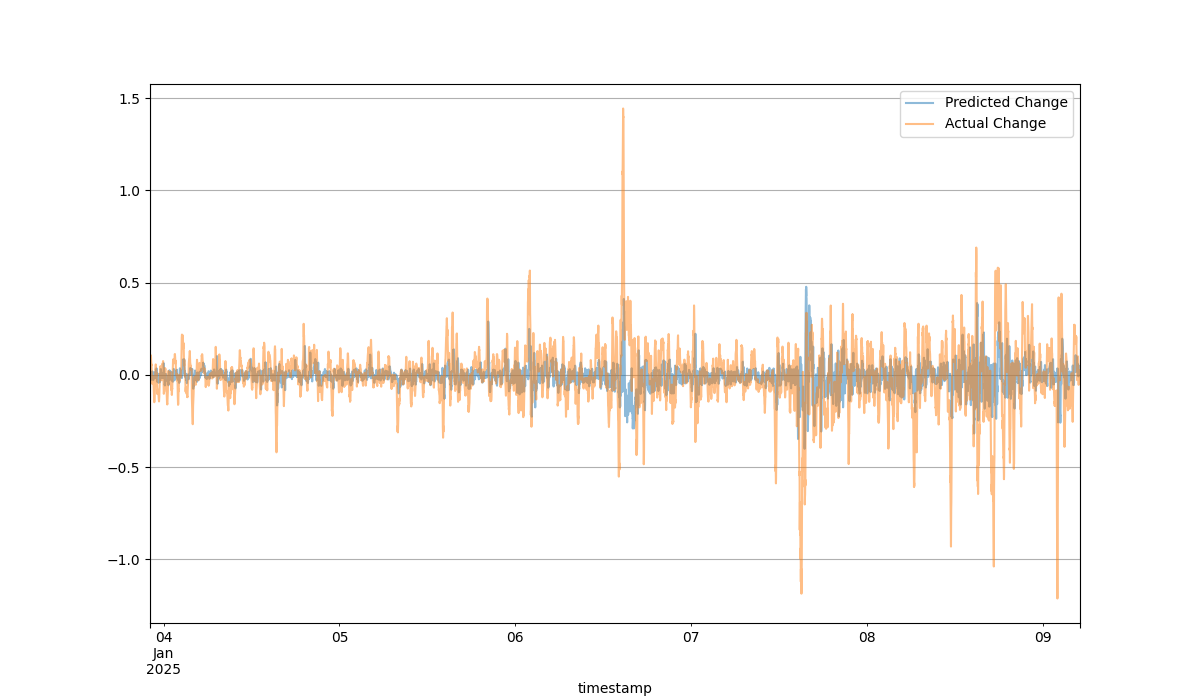

In [32]:
# results_df['Actual Future Price'] = results_df['close']  # Actual future close price

plt.clf()
plt.figure(figsize=(12, 7))
# results_df['Predicted Price'].plot()
# results_df['close'].plot()
results_df['Predicted Change'].plot(alpha=0.5)
results_df['Actual Change'].plot(alpha=0.5)
plt.legend()
plt.grid()
plt.show()

In [35]:
def simulate_trades(signals, prices, initial_balance=1000):
    """
    Simulates trades based on signals and actual price changes.

    Args:
        actual_changes (list or pd.Series): Actual percentage changes (not predicted).
        signals (list): List of trading signals ("Buy", "Sell", "Hold").
        prices (list or pd.Series): Actual price values for the asset.
        initial_balance (float): Starting balance of the trading account.

    Returns:
        float: Final balance or cumulative profit.
    """
    balance = INITIAL_BALANCE
    position = 0  # Tracks the number of stocks held
    entry_price = None  # Store the price when a "Buy" was executed

    for i, signal in enumerate(signals):
        if signal == 1 and balance > 0:
            # Execute a buy
            entry_price = prices.iloc[i]  # Use .iloc for positional indexing
            position = balance / entry_price  # Buy with all available balance
            balance = 0  # All balance used to buy
        elif signal == -1 and position > 0:
            # Execute a sell
            exit_price = prices.iloc[i]  # Use .iloc for positional indexing
            balance = position * exit_price  # Convert position to cash
            position = 0  # Clear position
            entry_price = None  # Reset entry price after selling

    # If there's a remaining position at the end, calculate its value
    if position > 0 and entry_price is not None:
        balance += position * prices.iloc[-1]  # Use .iloc for positional indexing

    return balance - INITIAL_BALANCE  # Return cumulative profit


In [37]:
predict_ch_min = results_df["Predicted Change"].min()
predict_ch_max = results_df["Predicted Change"].max()
print(f'Min Change: {predict_ch_min}')
print(f'Max Change: {predict_ch_max}')

Min Change: -0.4014474153518677
Max Change: 0.47723299264907837


In [38]:
# Define buy and sell thresholds (e.g., absolute differences in predicted vs. actual price)
sell_thresholds = np.arange(predict_ch_min, -0.0001, 0.005)  # Thresholds for when to "Sell"; Sell when price is predicted to go down
buy_thresholds = np.arange(0.0001, predict_ch_max, 0.005)   # Thresholds for when to "Buy"; buy when price is predicted to go up

best_buy_threshold = None
best_sell_threshold = None
best_performance = -np.inf

ii = 0
jj = 0
performance = np.zeros((len(buy_thresholds), len(sell_thresholds)))
# -1 = Sell
# 0 = Hold
# 1 = Buy
for buy_th in buy_thresholds:
    for sell_th in sell_thresholds:
        # Generate signals
        trading_signals = [
            -1 if pred < sell_th else 1 if pred > buy_th else 0
            for pred in results_df['Predicted Change']
        ]

        # Simulate trades and calculate performance
        performance[ii, jj] = simulate_trades(
            signals=trading_signals,
            prices=results_df['close'],  # Use the computed predicted prices
            initial_balance=INITIAL_BALANCE
        )
        # Update best thresholds if current performance is better
        if performance[ii, jj] > best_performance:
            best_performance = performance[ii, jj]
            best_buy_threshold = buy_th
            best_sell_threshold = sell_th
        jj += 1
    ii += 1
    jj = 0
print(f"Best Buy Threshold: {best_buy_threshold}, Best Sell Threshold: {best_sell_threshold}")
print(f"Best Performance: {best_performance}")


Best Buy Threshold: 0.2301, Best Sell Threshold: -0.24144741535186753
Best Performance: 22.4185498255207


#### Beck Testing 

In [39]:
# Define buy & sell thrsholds
buy_threshold = best_buy_threshold
sell_threshold = best_sell_threshold
# Generate signals with reversed logic
trading_signals = [
    -1 if pred < sell_threshold else 1 if pred > buy_threshold else 0
    for pred in results_df['Predicted Change']
]

balance = INITIAL_BALANCE
position = 0  # No stock initially
trading_log = []  # To store completed trades



results_df['Signal'] = trading_signals

# Add 'open' and 'close' prices from the original DataFrame to results DataFrame
# results_df['open'] = df.loc[results_df.index, 'open']
# results_df['close'] = df.loc[results_df.index, 'close']

results_df.dropna(inplace=True)

# Variables to track ongoing trades
buy_price = None
buy_date = None
buy_volume = None

# Iterate over results_df for backtesting
for index, row in results_df.iterrows():
    signal = row['Signal']
    price = row['close']  # Use 'open' price for Buy

    if signal == 1 and balance > 0:
        # Record Buy details
        buy_price = price
        buy_date = index
        buy_volume = balance / price
        position = buy_volume  # Update position
        balance = 0  # All money is invested

    elif signal == -1 and position > 0:
        # Calculate profit/loss for the completed trade
        sell_price = price  # Use 'close' price for Sell
        profit_loss = (sell_price - buy_price) * buy_volume
        balance = sell_price * buy_volume  # Update balance after selling
        position = 0  # No stock left

        # Record the completed trade in the log
        trading_log.append({
            "Buy Date": buy_date,
            "Buy Price": buy_price,
            "Buy Volume": buy_volume,
            "Sell Date": index,
            "Sell Price": sell_price,
            "Profit/Loss": profit_loss
        })

        # Reset Buy details
        buy_price = None
        buy_date = None
        buy_volume = None

# Final portfolio value
if position > 0:
    final_price = results_df.iloc[-1]['Predicted Price']
    final_profit_loss = (final_price - buy_price) * buy_volume
    balance = final_price * buy_volume  # Update balance with remaining shares
    trading_log.append({
        "Buy Date": buy_date,
        "Buy Price": buy_price,
        "Buy Volume": buy_volume,
        "Sell Date": results_df.index[-1],
        "Sell Price": final_price,
        "Profit/Loss": final_profit_loss
    })

# Convert trading log to a DataFrame for better analysis
trading_log_df = pd.DataFrame(trading_log)

# Print the final results
print(f"Final Balance: ${balance:.2f}")
print(f"Net Profit: ${balance - INITIAL_BALANCE:.2f}")



Final Balance: $1022.42
Net Profit: $22.42


In [ ]:
# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predicted Change'], label='Predicted Change', color='blue', alpha=0.7)
plt.plot(results_df.index, y_test/100, label='Actual Change', color='red', alpha=0.7)


# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predicted Change'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predicted Change'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.6
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Save the model
joblib.dump(best_model, 'best_model_10candles_1min.joblib')

['best_model_10candles_1min.joblib']